*Goal*: find out if the dataset fits the data requirements

*Data Requirements*:
* user is present in all intervals
* user activity is >80%
* items are comparable
* timestamp
* implicit feedback
* ranking problem


# update sys.path

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

# imports

In [2]:
import pandas as pd 
# from data_utils import get_namepaths_amazon_digimusic_isgd
from data_utils import getDF
from dataset_evaluation_utils import filter_out_users_with_less_than_k_rates, split_timestamp, sample_time_period

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

___
# Amazon Digital Music
Small subset, ratings only.  


Ratings only: These datasets include no metadata or reviews, but only (item,user,rating,timestamp) tuples. 


https://nijianmo.github.io/amazon/index.html

## define variables

In [3]:
dataset_name = 'Amazon_Digital_Music'
user_col = 'user_id'
item_col = 'item_id'
rate_col = 'rating'
time_col = 'timestamp'

In [4]:
orig_df = pd.read_csv("../datasets/Digital_Music.csv", 
                            names=[item_col, user_col, rate_col, time_col])

orig_df.head()

,item_id,user_id,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400


In [5]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584082 entries, 0 to 1584081
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   item_id    1584082 non-null  object 
 1   user_id    1584082 non-null  object 
 2   rating     1584082 non-null  float64
 3   timestamp  1584082 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 48.3+ MB


In [6]:
orig_df[user_col] = orig_df[user_col].astype(str)#'category')
orig_df[item_col] = orig_df[item_col].astype(str)#'category')
#.apply(lambda x : str(x))

# how many interactions per time unit for a given user?

## remove duplicates? flag remove_duplicated_interactions

In [7]:
remove_duplicated_interactions = False

In [8]:
# there is a lot of duplicate entries...
orig_df[[user_col, item_col, time_col]].value_counts()

user_id               item_id     timestamp 
A3DG93E8TXMKZF        B001KOWH0G  1397520000    51
A23OB9FM3MUYXT        B00137ILRS  1332979200    18
                      B00137MMAU  1332115200    10
AWG2O9C42XW5G         9434682614  1396396800    10
A23OB9FM3MUYXT        B000VWMT7Y  1333324800    10
                                                ..
A3HWICCEA97SZ6        B00Y41VJ4M  1442534400     1
A3HWIG1CF0EYBA        B00NAPZIIG  1431734400     1
A3HWIHF2G2TQRH        B000VZIO0W  1421884800     1
                      B014EPXN64  1463702400     1
A00041408PB8URN3FSQ6  B003YPD15E  1436140800     1
Length: 1518306, dtype: int64

In [9]:
orig_df.loc[(orig_df[user_col]=='A3DG93E8TXMKZF') &
        (orig_df[item_col]=='B001KOWH0G') &
          (orig_df[time_col]==1397520000), rate_col].value_counts()

1.0    51
Name: rating, dtype: int64

In [10]:
orig_df.duplicated().any()

True

In [11]:
if remove_duplicated_interactions:
    data_clean = orig_df[~orig_df.duplicated()]
    print('is there duplicated interactions user A, item alpha, rate x, time z? ',data_clean.duplicated().any())
    print('percentage of rows kept: ', data_clean.shape[0]/orig_df.shape[0])
else:
    data_clean = orig_df.copy()
    print('is there duplicated interactions user A, item alpha, rate x, time z? ', data_clean.duplicated().any())

is there duplicated interactions user A, item alpha, rate x, time z?  True


## split_timestamp

In [12]:
data_clean = split_timestamp(data_clean)
data_clean.head()

,item_id,user_id,rating,timestamp,date,year-month,year,month,day
2092,9714721180,A2SY49Z6H96QVR,5.0,877305600,1997-10-20,1997-10-01,1997,10,20
83632,B0013D89TW,A2XT7XLQ8DD4NZ,5.0,880675200,1997-11-28,1997-11-01,1997,11,28
147526,B0013D89TW,A2XT7XLQ8DD4NZ,5.0,880675200,1997-11-28,1997-11-01,1997,11,28
117999,B00122Z4Y2,A3OS0Q4XX0QSA4,5.0,893203200,1998-04-22,1998-04-01,1998,4,22
54105,B00122Z4Y2,A3OS0Q4XX0QSA4,5.0,893203200,1998-04-22,1998-04-01,1998,4,22


# stats

In [232]:
d = data_clean[[user_col, item_col, 'rating', 'year-month', 'date']]
d.head()

,user_id,item_id,rating,year-month,date
2092,A2SY49Z6H96QVR,9714721180,5.0,1997-10-01,1997-10-20
83632,A2XT7XLQ8DD4NZ,B0013D89TW,5.0,1997-11-01,1997-11-28
147526,A2XT7XLQ8DD4NZ,B0013D89TW,5.0,1997-11-01,1997-11-28
117999,A3OS0Q4XX0QSA4,B00122Z4Y2,5.0,1998-04-01,1998-04-22
54105,A3OS0Q4XX0QSA4,B00122Z4Y2,5.0,1998-04-01,1998-04-22


# how many different users per month?

<AxesSubplot:title={'center':'how many different users per month'}, xlabel='year-month'>

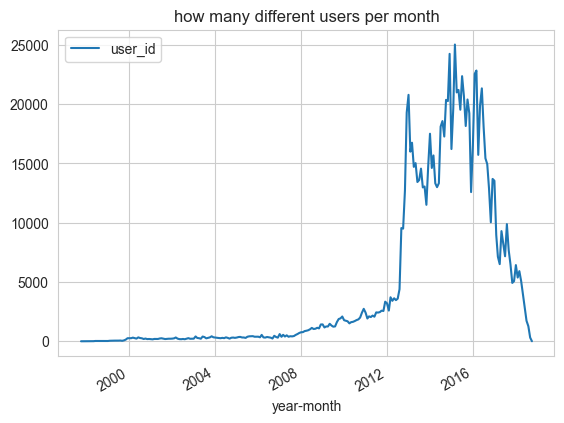

In [233]:
d[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby('year-month')\
            .count().plot(title='how many different users per month')

# how many months have more than 10k users?

In [234]:
(d[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby('year-month')\
            .count() >= 10000).value_counts()

user_id
False      198
True        51
dtype: int64

# how many months in a year have more than 10k users?

In [235]:
_ = d[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby('year-month')\
            .count().reset_index()
_.columns = ['year-month', 'users_count']


ym_list = _.loc[ _['users_count']>= 10000, 'year-month'].to_list() 

data_clean.loc[data_clean['year-month'].isin(ym_list),['year', 'year-month']].drop_duplicates().groupby('year').count()


,year-month
year,
2012,2
2013,12
2014,12
2015,12
2016,12
2017,1


years 2013 till 2017 are good to use

# how many users have more than k-interactions per month?

In [236]:
(d[[user_col, 'year-month']]\
        .value_counts() > 5).value_counts()

False    1125046
True       16819
dtype: int64

# get k-core/month users

In [242]:
k = 4
user_interactions_per_month = d[[user_col, 'year-month']]\
                                        .value_counts().to_frame('interactions_per_month').reset_index()
users_kcore_month_list = user_interactions_per_month.loc[user_interactions_per_month['interactions_per_month']>k, user_col].to_list()
users_kcore_month_list[:10]

['AV648VU7JR5D5',
 'A1Q0BU32CVOLRA',
 'A2RNYF2PTOB82J',
 'A1Q0BU32CVOLRA',
 'A15T3Y3BL2AJ9V',
 'AIZWM3J1HG027',
 'AAFW69F6T4CIX',
 'A30QGCSBD37MFR',
 'A264LJ7DXWHJQH',
 'A2TXKUC8SN53H7']

# k-core/month-users' interactions per month

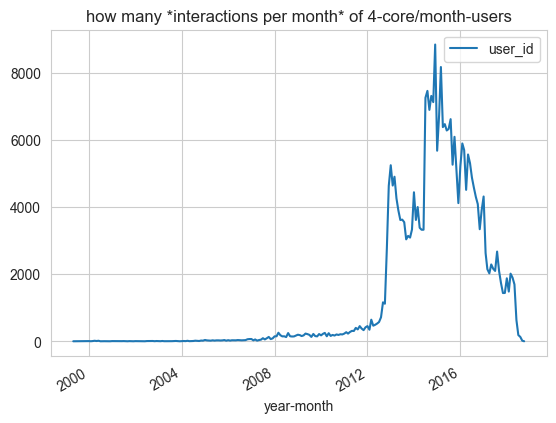

In [245]:
dc_kcore_filter = data_clean[user_col].isin(users_kcore_month_list)
data_clean.loc[dc_kcore_filter,[user_col, 'year-month']]\
                .groupby('year-month')\
                    .count().plot(title='how many *interactions per month* of '+str(k)+'-core/month-users');

if we bin it per trimestre, each bucket will have more interactions

# how many k-core-users per month?

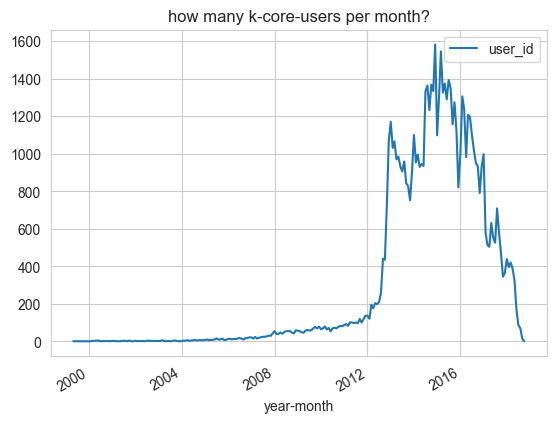

In [248]:
data_clean.loc[dc_kcore_filter, [user_col, 'year-month']]\
            .drop_duplicates()\
                .groupby('year-month')\
                    .count().plot(title='how many k-core-users per month?');

# how many months in a year have more than 790 k-core/month-users?

In [253]:
_ = data_clean.loc[dc_kcore_filter, [user_col, 'year-month']]\
            .drop_duplicates()\
                .groupby('year-month')\
                    .count().reset_index()
_.columns = ['year-month', 'users_count']


ym_list = _.loc[ _['users_count']>= 790, 'year-month'].to_list() 

data_clean.loc[dc_kcore_filter &\
               data_clean['year-month'].isin(ym_list), ['year', 'year-month']]\
        .drop_duplicates() \
            .groupby('year').count()

,year-month
year,
2012,1
2013,11
2014,12
2015,12
2016,12
2017,1


# filter data with time period and 5-core/month users

In [207]:
time_period = [('2013-01', '%Y-%m'), ('2017-01', '%Y-%m')]
_ = data_clean[(data_clean['year-month'] >= datetime.strptime(*time_period[0])) & \
                  (data_clean['year-month'] < datetime.strptime(*time_period[1])) &\
                    (data_clean[user_col].isin(users_5core_month_list))]
_

,item_id,user_id,rating,timestamp,date,year-month,year,month,day
1088994,B006CLTRAK,A2PT5T9P73GXY,5.0,1356998400,2013-01-01,2013-01-01,2013,1,1
34656,B000W1Y288,A3BIV1X1K9R796,4.0,1356998400,2013-01-01,2013-01-01,2013,1,1
49064,B0011Z92SY,A271N27P1BBOSX,5.0,1356998400,2013-01-01,2013-01-01,2013,1,1
34432,B000W1W8UW,AS02LU5CR8VJP,5.0,1356998400,2013-01-01,2013-01-01,2013,1,1
664067,B000TE51UG,A3BIV1X1K9R796,5.0,1356998400,2013-01-01,2013-01-01,2013,1,1
...,...,...,...,...,...,...,...,...,...
1282202,B00FLJXO76,A2JD867TZIEXG,5.0,1483142400,2016-12-31,2016-12-01,2016,12,31
580533,B01D41ASOE,A2O1EBPCAGFQ88,3.0,1483142400,2016-12-31,2016-12-01,2016,12,31
1541813,B01ABBHWPS,A18LYA95666ABF,5.0,1483142400,2016-12-31,2016-12-01,2016,12,31
1427508,B00QM9R84E,A2O1EBPCAGFQ88,4.0,1483142400,2016-12-31,2016-12-01,2016,12,31


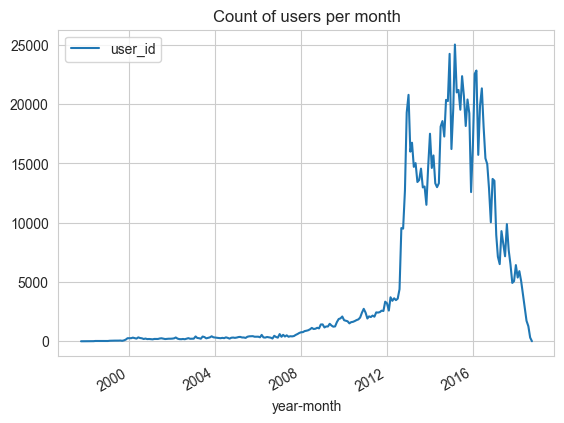

In [35]:
data_clean[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby(['year-month'])\
            .count()\
                .plot(title='Count of users per month');

In [53]:
user_interactions_per_month = data_clean[[user_col, 'year-month']].value_counts()\
                                        .to_frame(name='count_user_interactions_per_year-month')

user_interactions_per_month = user_interactions_per_month.reset_index()#['year-month'])
user_interactions_per_month[user_col] = user_interactions_per_month[user_col].astype('category')

user_interactions_per_month.head()

,user_id,year-month,count_user_interactions_per_year-month
0,AV648VU7JR5D5,2017-06-01,182
1,A1Q0BU32CVOLRA,2015-10-01,140
2,A2RNYF2PTOB82J,2016-02-01,132
3,A1Q0BU32CVOLRA,2016-10-01,130
4,A15T3Y3BL2AJ9V,2016-11-01,126


In [37]:
data_clean.loc[(data_clean[user_col]=='A1Q0BU32CVOLRA') &\
           (data_clean['year-month']=='2015-10-01'), item_col].nunique()

140

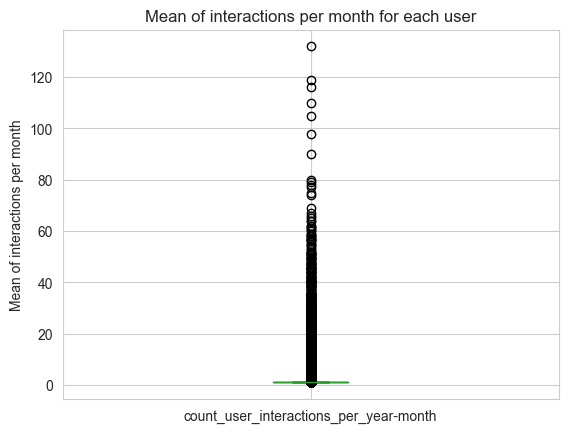

In [54]:
user_interactions_per_month[[user_col, 'count_user_interactions_per_year-month']]\
                    .groupby(user_col)\
                        .mean()\
                            .plot(kind='box',
                                  ylabel='Mean of interactions per month',
                                  #   xlabel='...',
                                  title='Mean of interactions per month for each user');

In [55]:
user_interactions_per_month

,user_id,year-month,count_user_interactions_per_year-month
0,AV648VU7JR5D5,2017-06-01,182
1,A1Q0BU32CVOLRA,2015-10-01,140
2,A2RNYF2PTOB82J,2016-02-01,132
3,A1Q0BU32CVOLRA,2016-10-01,130
4,A15T3Y3BL2AJ9V,2016-11-01,126
...,...,...,...
1141860,A3EFUSFJ9PTT0Y,2013-04-01,1
1141861,A3EFUSFJ9PTT0Y,2010-04-01,1
1141862,A3EFU2TTY7IK1T,2015-12-01,1
1141863,A3EFTGAKOR5218,2017-01-01,1


In [57]:
data_clean['year-month'].value_counts()

2015-03-01    36375
2014-12-01    36071
2015-07-01    31225
2016-03-01    30995
2016-02-01    30694
              ...  
1998-05-01        9
1998-04-01        3
2018-10-01        3
1997-11-01        2
1997-10-01        1
Name: year-month, Length: 249, dtype: int64

In [ ]:
data_clean[[user_col, 'year-month']].value_counts() /

In [59]:
user_interactions_per_month[['year-month','count_user_interactions_per_year-month']]\
        .groupby(['year-month']).mean()

,count_user_interactions_per_year-month
year-month,
1997-10-01,1.000000
1997-11-01,2.000000
1998-04-01,1.500000
1998-05-01,1.000000
1998-06-01,1.240000
...,...
2018-06-01,1.290479
2018-07-01,1.158749
2018-08-01,1.113904


In [76]:
user_interactions_per_month.loc[user_interactions_per_month['year-month']=='2015-03-01', user_col].nunique()

25024

<AxesSubplot:>

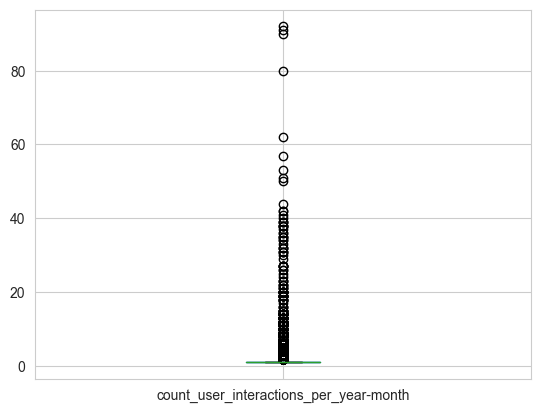

In [74]:
user_interactions_per_month[user_interactions_per_month['year-month']=='2015-03-01'].plot(kind='box')

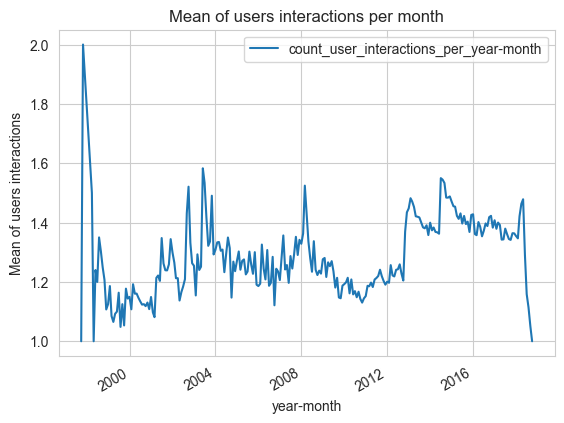

In [64]:
user_interactions_per_month[['year-month','count_user_interactions_per_year-month']]\
        .groupby(['year-month'])\
            .mean()\
                .plot( ylabel='Mean of users interactions',
                      title='Mean of users interactions per month');

In [17]:
# I wanted to plot the user interactions per month color mapped by user. Didnt work

# %time
# user_interactions_per_month.plot(x = 'year-month',
#                                 y = 'user_interactions_per_year-month',
#                                 label = 'user_id',
#                                 kind = 'scatter',
#                                 title = 'Count of users per month');



# another try

# import plotly.graph_objs as pgo
# import plotly.offline as py

# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

# a4_dims = (11.7, 8.27)

# fig = user_interactions_per_month.plot(x = 'year-month',
#                                        y = 'user_interactions_per_year-month',
#                                        color = 'user_id',
#                                        title = 'Count of users per month',
#                                        markers = True,
#                                        symbol = 'user_id',
#                                        kind = 'line')

# plot Distribution of the rate frequency of users & the rate count of users

A3W4D8XOGLWUN5    1255
AQ4B80F0JSBNI      659
A1Q0BU32CVOLRA     638
A2WQY1B8ZS7QRZ     534
A2H3JURQZOHVMB     484
                  ... 
A31QBTPDCRU0FF       1
A1NBZMGXBMBO7I       1
A12FRB58RESCPA       1
ACRTMVSN18WIU        1
A8UWD30ZY9E92        1
Name: user_id, Length: 840372, dtype: int64


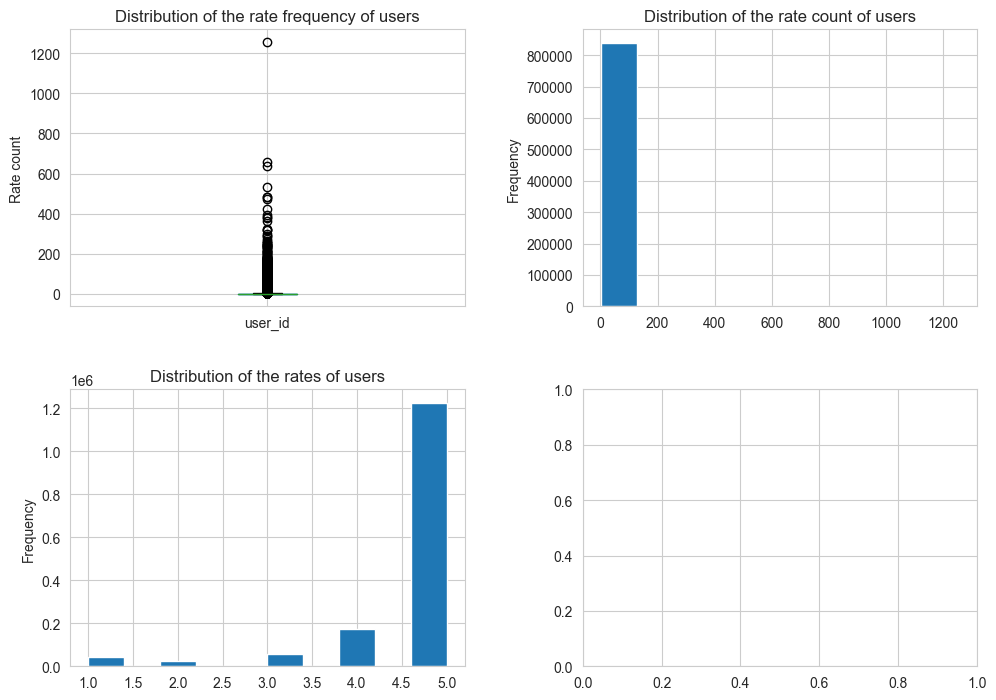

In [21]:
# print(data_period[user_col].value_counts())

# fig, axes = plt.subplots(nrows=2, 
#                          ncols=2, 
#                          figsize=a4_dims,
#                          gridspec_kw={'wspace':0.3,
#                                       'hspace':0.3})
# data_period[user_col].value_counts().plot(kind='box', 
#                                             ax=axes[0,0],
#                                             ylabel='Rate count',
#                                             title='Distribution of the rate frequency of users');
# data_period[user_col].value_counts().plot(kind='hist', 
#                                             ax=axes[0,1],
#                                             xlabel='Rate count',
#                                             title='Distribution of the rate count of users');
# data_period[rate_col].plot(kind='hist',
#                              ax=axes[1,0],
#                              title='Distribution of the rates of users');

print(data_clean[user_col].value_counts())

fig, axes = plt.subplots(nrows=2, 
                         ncols=2, 
                         figsize=a4_dims,
                         gridspec_kw={'wspace':0.3,
                                      'hspace':0.3})
data_clean[user_col].value_counts().plot(kind='box', 
                                            ax=axes[0,0],
                                            ylabel='Rate count',
                                            title='Distribution of the rate frequency of users');
data_clean[user_col].value_counts().plot(kind='hist', 
                                            ax=axes[0,1],
                                            xlabel='Rate count',
                                            title='Distribution of the rate count of users\nxlabel=Rate count');
data_clean[rate_col].plot(kind='hist',
                             ax=axes[1,0],
                             title='Distribution of the rates of users\nxlabel=rates');

# filter_out_users_with_less_than_k_rates

A3W4D8XOGLWUN5    1255
AQ4B80F0JSBNI      659
A1Q0BU32CVOLRA     638
A2WQY1B8ZS7QRZ     534
A2H3JURQZOHVMB     484
                  ... 
A8W4EX99OXJQ5       24
A2JBV777WJKXWP      24
AJG0NKGWBSIYI       24
A13BFEAT5JMY72      24
AOJHKGGSQPAYN       24
Name: user_id, Length: 2896, dtype: int64
(136597, 9)


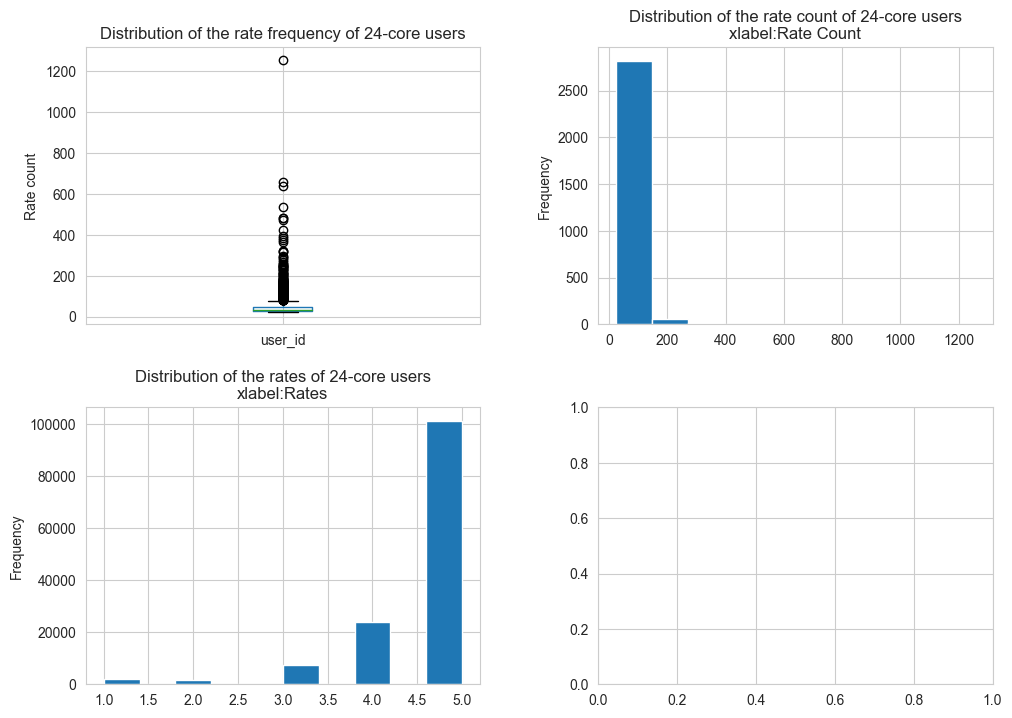

In [22]:
k = 24
# data_kcore = filter_out_users_with_less_than_k_rates(data_period, k=k) #12 -> 1 interaction/month
data_kcore = filter_out_users_with_less_than_k_rates(data_clean, k=k) #12 -> 1 interaction/month

print(data_kcore[user_col].value_counts())
print(data_kcore.shape)

fig, axes = plt.subplots(nrows=2, 
                         ncols=2, 
                         figsize=a4_dims,
                         gridspec_kw={'wspace':0.3,
                                      'hspace':0.3})
data_kcore[user_col].value_counts().plot(kind='box', 
                                            ax=axes[0,0],
                                            ylabel='Rate count',
                                            title='Distribution of the rate frequency of '+str(k)+'-core users');
data_kcore[user_col].value_counts().plot(kind='hist', 
                                            ax=axes[0,1],
                                            title='Distribution of the rate count of '+str(k)+'-core users\nxlabel:Rate Count');
data_kcore[rate_col].plot(kind='hist',
                             ax=axes[1,0],
                             title='Distribution of the rates of '+str(k)+'-core users\nxlabel:Rates');


# select time period to work in

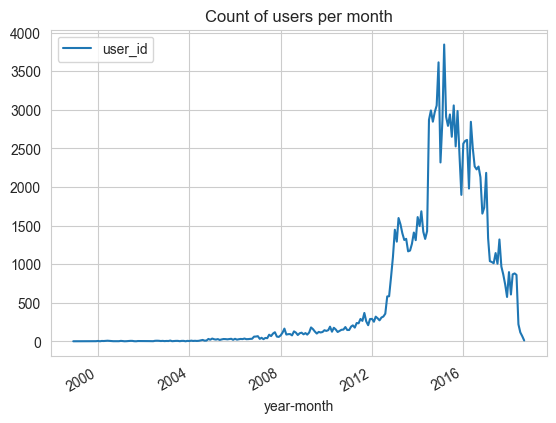

In [23]:
data_kcore[[user_col, 'year-month']]\
    .groupby(['year-month']).count()\
        .plot(title='Count of users per month');

2012-01 2013-01 97064
2013-01 2014-01 236654
2014-01 2015-01 284778
2015-01 2016-01 324129
2016-01 2017-01 276272
2012-01 2014-01 333718
2014-01 2016-01 608907


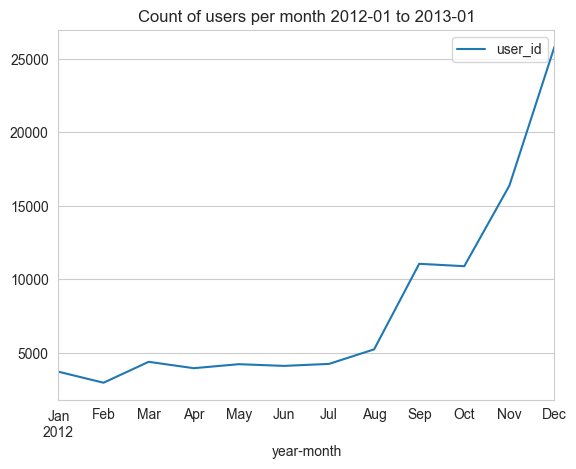

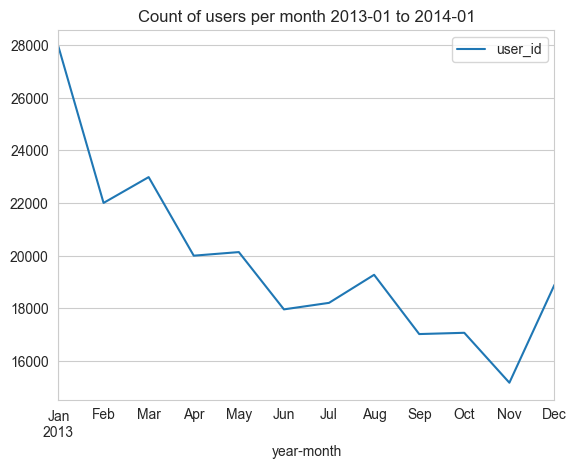

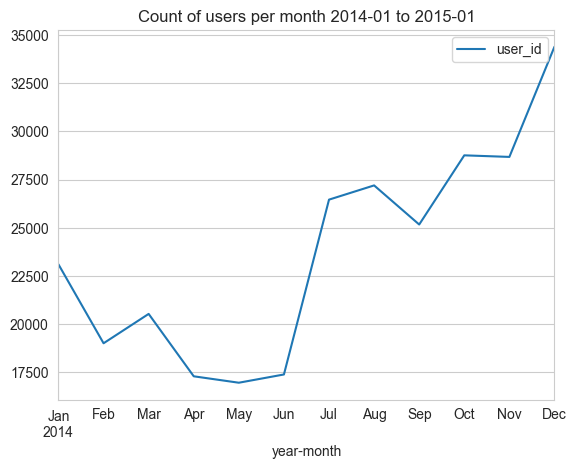

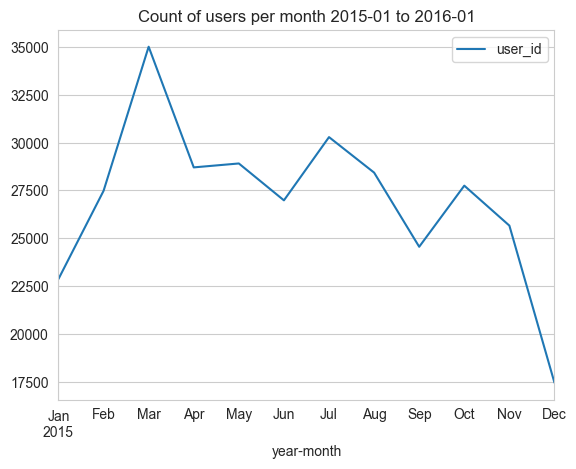

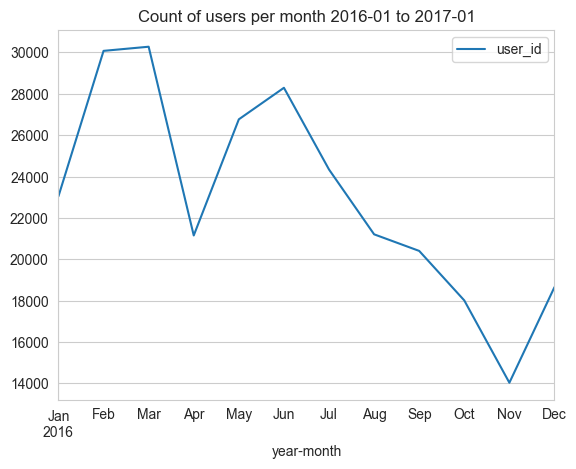

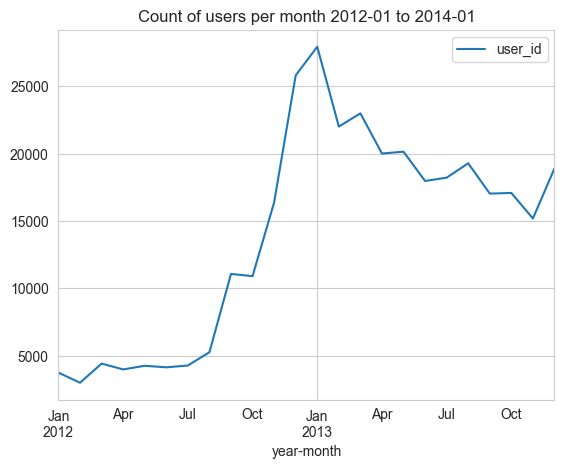

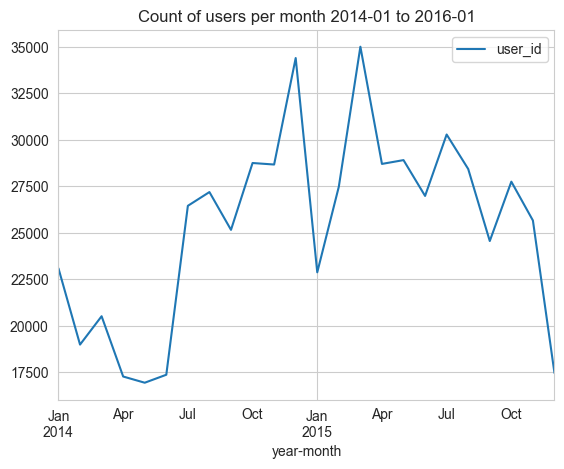

In [28]:
time_period_list =  [[('2012-01', '%Y-%m'), ('2013-01', '%Y-%m')],
                     [('2013-01', '%Y-%m'), ('2014-01', '%Y-%m')],
                     [('2014-01', '%Y-%m'), ('2015-01', '%Y-%m')],
                     [('2015-01', '%Y-%m'), ('2016-01', '%Y-%m')],
                     [('2016-01', '%Y-%m'), ('2017-01', '%Y-%m')],
                     [('2012-01', '%Y-%m'), ('2014-01', '%Y-%m')],
                     [('2014-01', '%Y-%m'), ('2016-01', '%Y-%m')]]

for time_period in time_period_list:
    _, _start, _end = sample_time_period(time_period, data_clean)
    print(_start,_end, _.shape[0])

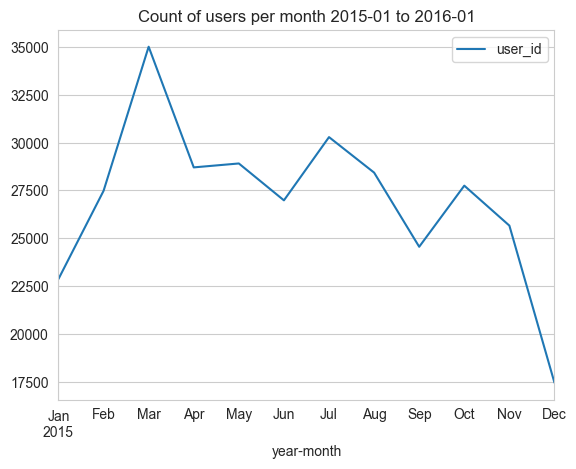

In [15]:
# the time period with lower peeks was chosen
time_period =  [('2015-01', '%Y-%m'), ('2016-01', '%Y-%m')]
data_period, time_period_start, time_period_end = sample_time_period(time_period, data_clean)

# meta data

In [5]:
meta_dm = getDF('../datasets/meta_Digital_Music.json.gz')
'''
where

asin - ID of the product, e.g. 0000031852
title - name of the product
feature - bullet-point format features of the product
description - description of the product
price - price in US dollars (at time of crawl)
imageURL - url of the product image
imageURL - url of the high resolution product image
related - related products (also bought, also viewed, bought together, buy after viewing)
salesRank - sales rank information
brand - brand name
categories - list of categories the product belongs to
tech1 - the first technical detail table of the product
tech2 - the second technical detail table of the product
similar - similar product table
'''

meta_dm.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,[],,[],,Master Collection Volume One,"[B000002UEN, B000008LD5, B01J804JKE, 747403435...",,John Michael Talbot,[],"58,291 in CDs & Vinyl (","[B000002UEN, B000008LD5, 7474034352, B000008LD...","<img src=""https://images-na.ssl-images-amazon....",,,$18.99,0001377647,[],[],NaN
1,[],,[],,Hymns Collection: Hymns 1 &amp; 2,"[5558154950, B00014K5V4]",,Second Chapter of Acts,[],"93,164 in CDs & Vinyl (","[B000008KJ3, B000008KJ0, 5558154950, B000UN8KZ...","<img src=""https://images-na.ssl-images-amazon....",,,,0001529145,[],[],NaN
2,[],,[],,Early Works - Don Francisco,"[B00004RC05, B003H8F4NA, B003ZFVHPO, B003JMP1Z...",,Don Francisco,[],"875,825 in CDs & Vinyl (","[B003H8F4NA, B003ZFVHPO, B003JMP1ZK, B00004RC0...","<img src=""https://images-na.ssl-images-amazon....",,,,0001527134,[],[],NaN
3,[],,[],,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2G...",,Keith Green,[],"203,263 in CDs & Vinyl (","[B00000I7JO, B0016CP2GS, 0001393774, B0000275Q...","<img src=""https://images-na.ssl-images-amazon....",,,$13.01,0001388703,[],[],NaN
4,[],,[1. Losing Game 2. I Can't Wait 3. Didn't He S...,,Early Works - Dallas Holm,"[B0002N4JP2, 0760131694, B00002EQ79, B00150K8J...",,Dallas Holm,[],"399,269 in CDs & Vinyl (","[B0002N4JP2, 0760131694, B00150K8JC, B003MTXNV...","<img src=""https://images-na.ssl-images-amazon....",,,,0001526146,[],[],NaN
